In [10]:
import pandas as pd
import numpy as np; np.random.seed(42);
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import geopandas as gpd
from remap import *
from osgeo import osr
from sklearn.cluster import KMeans
import cv2
# mean shift approachs can't be used in data bigger then 10.000 points
#See: https://books.google.com.br/books?id=HvKoCwAAQBAJ&pg=PA299&lpg=PA299&dq=Mastering+SciPy+meanshift&source=bl&ots=ZIsPs7uIlU&sig=ACfU3U3DH65i2F_QZMEQ85WCm6iukZf0SA&hl=pt-PT&sa=X&ved=2ahUKEwiK3dS63ZflAhWVIrkGHegvA0sQ6AEwAHoECAkQAQ#v=onepage&q=Mastering%20SciPy%20meanshift&f=false
from sklearn.cluster import MeanShift, estimate_bandwidth
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

In [14]:
file = "OR_ABI-L2-CMIPF-M3C13_G17_s20190010030381_e20190010041159_c20190010041214.nc"
thresold = 253
bbox = [-53.08059692, -25.25489044, -44.20065689, -19.78015137]

grid = remap(file, bbox, 2, 'NETCDF')
channel = file.split('-')[3][3:5]
year = file.split('s')[1][:4]
day = file.split('s')[1][4:7]
hour = file.split('s')[1][7:9]
minute = file.split('s')[1][9:11]
second = '%s'%file.split('s')[1][11:13]
second += '.%s'%file.split('s')[1][13:14]
title = 'GOES-16 ABI Band %s'%channel
title += '\n Scan from %s'%year
title += ' Day %s'%day
title += ' - %s'%hour
title += ':%s'%minute
title += ':%s UTC to '%second

year = file.split('e')[1][:4]
day = file.split('e')[1][4:7]
hour = file.split('e')[1][7:9]
minute = file.split('e')[1][9:11]
second = '%s'%file.split('e')[1][11:13]
second += '.%s'%file.split('e')[1][13:14]
title += '\n Scan from %s'%year
title += ' Day %s'%day
title += ' - %s'%hour
title += ':%s'%minute
title += ':%s UTC'%second

Remapping OR_ABI-L2-CMIPF-M3C13_G17_s20190010030381_e20190010041159_c20190010041214.nc
- finished! Time: 0.07618427276611328 seconds


In [3]:
ds = Dataset(file)
ds.variables.keys()

odict_keys(['CMI', 'DQF', 't', 'y', 'x', 'time_bounds', 'goes_imager_projection', 'y_image', 'y_image_bounds', 'x_image', 'x_image_bounds', 'nominal_satellite_subpoint_lat', 'nominal_satellite_subpoint_lon', 'nominal_satellite_height', 'geospatial_lat_lon_extent', 'band_wavelength', 'band_id', 'total_number_of_points', 'valid_pixel_count', 'outlier_pixel_count', 'min_brightness_temperature', 'max_brightness_temperature', 'mean_brightness_temperature', 'std_dev_brightness_temperature', 'esun', 'kappa0', 'planck_fk1', 'planck_fk2', 'planck_bc1', 'planck_bc2', 'algorithm_dynamic_input_data_container', 'percent_uncorrectable_GRB_errors', 'percent_uncorrectable_L0_errors', 'earth_sun_distance_anomaly_in_AU', 'processing_parm_version_container', 'algorithm_product_version_container'])

In [4]:
grid = grid.ReadAsArray()
grid

array([[276.74536, 276.74536, 277.91296, ..., 294.7512 , 294.87408,
        294.87408],
       [276.13083, 276.13083, 276.25372, ..., 294.81265, 294.81265,
        294.68973],
       [273.05817, 276.13083, 276.25372, ..., 294.7512 , 294.7512 ,
        294.81265],
       ...,
       [267.71173, 267.71173, 263.96307, ..., 292.17014, 292.17014,
        292.17014],
       [266.17538, 262.4882 , 258.18646, ..., 292.29306, 292.17014,
        292.17014],
       [261.5664 , 256.9574 , 248.90701, ..., 292.29306, 292.29306,
        292.17014]], dtype=float32)

In [5]:
np.arange(10).reshape((5, 2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

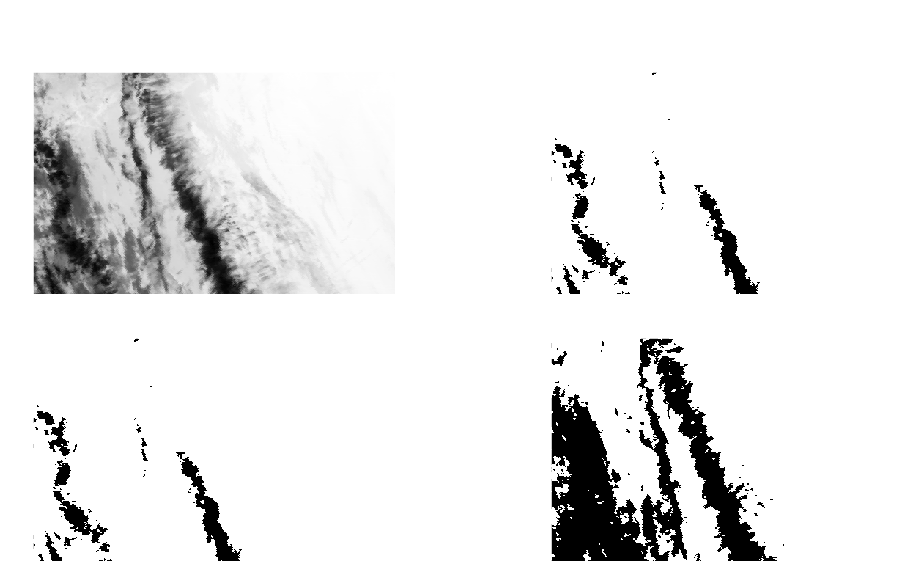

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(17, 9))

thresold = 230
manually = np.where(grid>thresold, 1, 0)
ocv = cv2.threshold(grid, thresold, np.max(grid), cv2.THRESH_BINARY)[1]

img = grid.reshape((-1, 1))
kmeans = KMeans(n_clusters=2, random_state=42).fit(img)
labels = kmeans.labels_
cluster = labels.reshape(grid.shape)
# cluster = np.flip(cluster, axis=0)


ax[0][0].imshow(grid, cmap='gray');ax[0][0].set_title('Original')
ax[0][0].xaxis.set_major_locator(ticker.MultipleLocator(50))
ax[0][0].xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax[0][1].imshow(manually, cmap='gray');ax[0][1].set_title('Manually')
ax[1][0].imshow(ocv, cmap='gray');ax[1][0].set_title('OpenCV')
ax[1][1].imshow(cluster, cmap='gray_r');ax[1][1].set_title('KMeans')

fig.suptitle('Segmentation using multiples approachs', 
            fontsize="x-large")
plt.show()

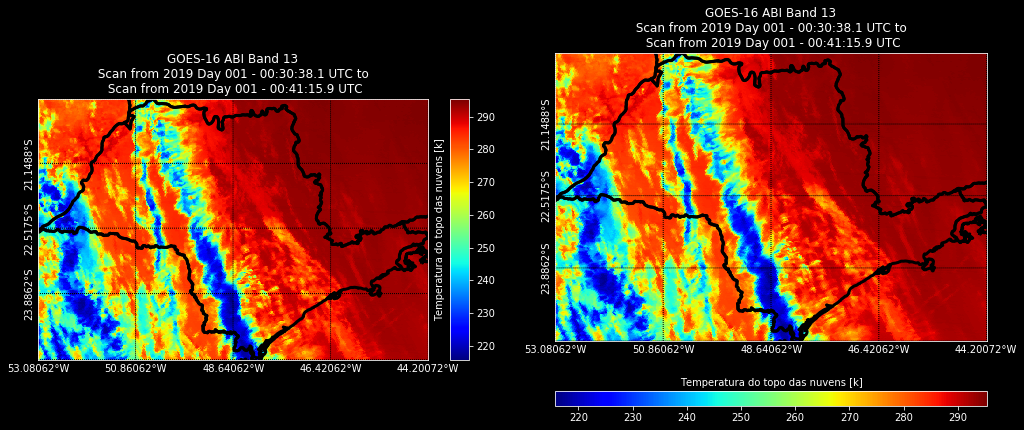

In [13]:
img = grid
resolution = 1

fig, ax = plt.subplots(1, 2, figsize=(17, 8))

m = Basemap(projection='merc', llcrnrlon=bbox[0], llcrnrlat=bbox[1],
       urcrnrlon=bbox[2], urcrnrlat=bbox[3], ax=ax[0])
m.readshapefile('./shapes/Brazilian_States_Shape/BRA_adm1', 'states',
               linewidth=3, color='k')
m.drawmeridians(np.linspace(bbox[0], bbox[2], 5), labels=[1, 0, 0, 1],
               textcolor='w', fmt='%g2')
m.drawparallels(np.linspace(bbox[1], bbox[3], 5), labels=[1, 0, 0, 1],
               textcolor='w', rotation=90)
im = m.imshow(np.flip(img, axis=0), cmap='jet')
divider = make_axes_locatable(ax[0])
ax[0].set_title('GOES 16 ABI')
ax[0].set_title(title)
cax = divider.append_axes('right', size='5%', pad=0.3)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label(labelpad=-60, label='Temperatura do topo das nuvens [k]')


m = Basemap(projection='merc', llcrnrlon=bbox[0], llcrnrlat=bbox[1],
       urcrnrlon=bbox[2], urcrnrlat=bbox[3], ax=ax[1])
m.readshapefile('./shapes/Brazilian_States_Shape/BRA_adm1', 'states',
               linewidth=3, color='k')
m.drawmeridians(np.linspace(bbox[0], bbox[2], 5), labels=[1, 0, 0, 1],
               textcolor='w', fmt='%g2')
m.drawparallels(np.linspace(bbox[1], bbox[3], 5), labels=[1, 0, 0, 1],
               textcolor='w', rotation=90)
im = m.imshow(np.flip(img, axis=0), cmap='jet')
divider = make_axes_locatable(ax[1])
ax[1].set_title(title)
cax = divider.append_axes('bottom', size='5%', pad=0.7)
cb = fig.colorbar(im, cax=cax, orientation='horizontal')
cb.set_label(labelpad=-45, label='Temperatura do topo das nuvens [k]')


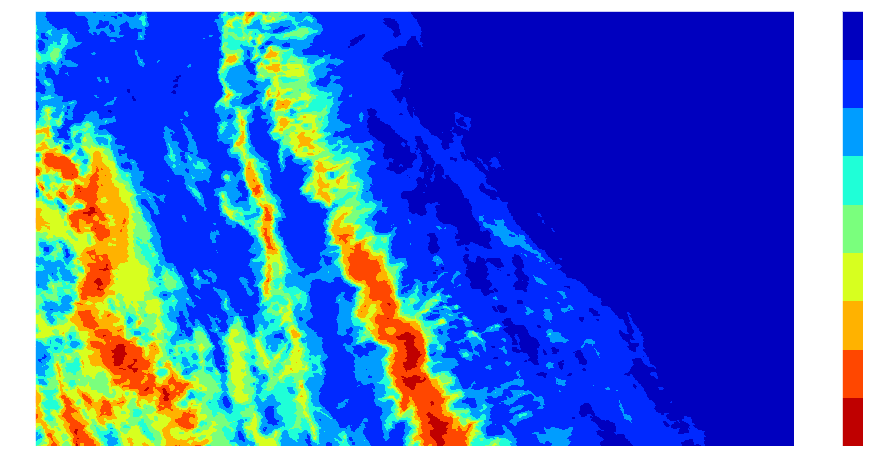

In [8]:
lon = np.linspace(bbox[0], bbox[2], grid.shape[1])
lat = np.linspace(bbox[1], bbox[3], grid.shape[0])
lon, lat = np.flip(np.meshgrid(lon, lat), axis=1)

plt.figure(figsize=(17, 8))
plt.contourf(lon, lat, grid, cmap='jet_r')
plt.colorbar()

In [9]:
temp = grid.reshape((-1, 1)).ravel()
np.where((temp>=290) & (temp<=300))[0].max()

150175